In [2]:
!pip install -q -U transformers pytorch_lightning sentencepiece sentence-transformers easydict

In [4]:
!git clone https://github.com/kisejin/My_Project_ABSA-QUAD.git

fatal: destination path 'My_Project_ABSA-QUAD' already exists and is not an empty directory.


In [5]:
!git pull

Already up to date.


In [3]:
%cd /notebooks/My_Project_ABSA-QUAD

/notebooks/My_Project_ABSA-QUAD


In [5]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cp /content/drive/MyDrive/Model_ProjectHotel/outputs.zip /content/
%cd /content/
!unzip outputs.zip

# Training time

In [36]:
# --model_name_or_path t5-base \
# general task: asqp
# genral train_batch_size, eval_batch_size: 16

!python main.py --task tasd \
            --dataset mydata1 \
            --model_name_or_path t5-base \
            --n_gpu 0 \
            --do_train \
            --do_direct_eval \
            --train_batch_size 16 \
            --gradient_accumulation_steps 1 \
            --eval_batch_size 16 \
            --learning_rate 3e-4 \
            --num_train_epochs 20

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



 ============================== NEW EXP: ASQP on mydata1 ============================== 

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `l

Save model to file zip

In [37]:
# zip file
# import shutil
# shutil.make_archive('/notebooks/output', 'zip', '/notebooks/My_Project_ABSA-QUAD/outputs')

import shutil
shutil.make_archive('/notebooks/output1', 'zip', '/notebooks/My_Project_ABSA-QUAD/outputs/mydata1')

'/notebooks/output1.zip'

# Define data loader , data preprocessing
* Must run

In [24]:
# File data_utils.py
# -*- coding: utf-8 -*-

# This script contains all data transformation and reading

import random
import re
import regex as reg
from torch.utils.data import Dataset

senttag2word = {"POS": "positive", "NEG": "negative", "NEU": "neutral"}
senttag2opinion = {"POS": "great", "NEG": "bad", "NEU": "ok"}
sentword2opinion = {"positive": "great", "negative": "bad", "neutral": "ok"}

aspect_cate_list = [
    "location general",
    "food prices",
    "food quality",
    "food general",
    "ambience general",
    "service general",
    "restaurant prices",
    "drinks prices",
    "restaurant miscellaneous",
    "drinks quality",
    "drinks style_options",
    "restaurant general",
    "food style_options",
    "facility",
    "amenity",
    "service",
    "experience",
    "branding",
    "loyalty",
]


def read_line_examples_from_file(data_path, silence=False):
    """
    Read data from file, each line is: sent####labels
    Return List[List[word]], List[Tuple]
    """
    id_users, sents, labels = [], [], []
    with open(data_path, "r", encoding="UTF-8") as fp:
        words, labels = [], []
        for line in fp:
            line = line.strip()
            if line != "":
                words, tuples = line.split("####")
                if tuples != "":
                    labels.append(eval(tuples))
                else:
                    words = line
                # Get id user at the beginning of line if it exist
                words = words.split()
                if len(words[0].split(',', 1)) > 1:
                    id_user, word = words[0].split(',',1)
                    words[0] = word
                    id_users.append(int(id_user))
                sents.append(words)

    if silence:
        print(f"Total examples = {len(sents)}")
    return id_users, sents, labels


def get_para_aste_targets(sents, labels):
    targets = []
    for i, label in enumerate(labels):
        all_tri_sentences = []
        for tri in label:
            # a is an aspect term
            if len(tri[0]) == 1:
                a = sents[i][tri[0][0]]
            else:
                start_idx, end_idx = tri[0][0], tri[0][-1]
                a = " ".join(sents[i][start_idx : end_idx + 1])

            # b is an opinion term
            if len(tri[1]) == 1:
                b = sents[i][tri[1][0]]
            else:
                start_idx, end_idx = tri[1][0], tri[1][-1]
                b = " ".join(sents[i][start_idx : end_idx + 1])

            # c is the sentiment polarity
            c = senttag2opinion[tri[2]]  # 'POS' -> 'good'

            one_tri = f"It is {c} because {a} is {b}"
            all_tri_sentences.append(one_tri)
        targets.append(" [SSEP] ".join(all_tri_sentences))
    return targets


def get_para_tasd_targets(sents, labels):
    targets = []
    for label in labels:
        all_tri_sentences = []
        for triplet in label:

            at, ac, sp = triplet
            at, ac, sp = at.lower(), ac.lower(), sp.lower()

            # Remove special characters in the end of aspect term
            at = re.sub(r'([^\w\s]|_)+(?=\s|$)', '', at)

            man_ot = sentword2opinion[sp]  # 'positive' -> 'great'

            if at == "NULL" or at == '':
                at = "it"

            one_tri = f"{ac} is {man_ot} because {at} is {man_ot}"

            # if at == '' or ac == '' or sp == '':
            #   print(f"Triplet: {triplet} ")

            all_tri_sentences.append(one_tri)

        target = " [SSEP] ".join(all_tri_sentences)
        targets.append(target)
    return targets


def get_para_asqp_targets(sents, labels):
    """
    Obtain the target sentence under the paraphrase paradigm
    """
    targets = []
    for label in labels:
        all_quad_sentences = []
        for quad in label:
            at, ac, sp, ot = quad
            at, ac, sp, ot = at.lower(), ac.lower(), sp.lower(), ot.lower()
            man_ot = sentword2opinion[sp]  # 'POS' -> 'good'

            if at == "NULL":  # for implicit aspect term
                at = "it"

            one_quad_sentence = f"{ac} is {man_ot} because {at} is {ot}"
            all_quad_sentences.append(one_quad_sentence)

        target = " [SSEP] ".join(all_quad_sentences)
        targets.append(target)
    return targets


def get_transformed_io(data_path, data_dir, task = 'asqp'):
    """
    The main function to transform input & target according to the task
    """
    id_user, sents, labels = read_line_examples_from_file(data_path)

    # the input is just the raw sentence
    inputs = [s.copy() for s in sents]
    targets = []

    if labels:
        if task == "aste":
            targets = get_para_aste_targets(sents, labels)
        elif task == "tasd":
            targets = get_para_tasd_targets(sents, labels)
        elif task == "asqp":
            targets = get_para_asqp_targets(sents, labels)
        else:
            raise NotImplementedError

    return id_user, inputs, targets


class ABSADataset(Dataset):
    def __init__(self, tokenizer, data_dir, data_type, task, max_len=128):
        # './data/rest16/train.txt'
        self.data_path = f"data/{data_dir}/{data_type}.txt"
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.data_dir = data_dir

        self.id_users = []
        self.inputs = []
        self.targets = []

        self.task = task

        self._build_examples()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index][
            "attention_mask"
        ].squeeze()  # might need to squeeze
        target_mask = self.targets[index][
            "attention_mask"
        ].squeeze()  # might need to squeeze

        return {
            "source_ids": source_ids,
            "source_mask": src_mask,
            "target_ids": target_ids,
            "target_mask": target_mask,
        }

    def _build_examples(self):
        id_user, inputs, targets = get_transformed_io(
            self.data_path, self.data_dir, self.task
        )

        check = 1 if len(id_user) > 0 else 0
        for i in range(len(inputs)):
            # change input and target to two strings
            input = " ".join(inputs[i])
            target = targets[i]

            tokenized_input = self.tokenizer.batch_encode_plus(
                [input],
                max_length=self.max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
            tokenized_target = self.tokenizer.batch_encode_plus(
                [target],
                max_length=self.max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
            if check:
                self.id_users.append(id_user[i])
            self.inputs.append(tokenized_input)
            self.targets.append(tokenized_target)
            

class ABSADataset_nolabel(Dataset):
    def __init__(self, tokenizer, data_dir, data_type, task, max_len=128):
        # './data/rest16/train.txt'
        self.data_path = data_dir
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.data_dir = data_dir

        self.id_users = []
        self.inputs = []

        self.task = task

        self._build_examples()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()

        src_mask = self.inputs[index][
            "attention_mask"
        ].squeeze()  # might need to squeeze

        return {
            "source_ids": source_ids,
            "source_mask": src_mask,
        }

    def _build_examples(self):
        id_user, inputs, _ = get_transformed_io(
            self.data_path, self.data_dir, self.task
        )

        check = 1 if len(id_user) > 0 else 0
        for i in range(len(inputs)):
            # change input and target to two strings
            input = " ".join(inputs[i])

            tokenized_input = self.tokenizer.batch_encode_plus(
                [input],
                max_length=self.max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )

            if check:
                self.id_users.append(id_user[i])
            self.inputs.append(tokenized_input)



# Data postprocessing and evaluation
* Must run

In [39]:
# File eval_utils.py
# -*- coding: utf-8 -*-

# This script handles the decoding functions and performance measurement

import re
from sentence_transformers import SentenceTransformer
import torch

sentiment_word_list = ['positive', 'negative', 'neutral']
opinion2word = {'great': 'positive', 'bad': 'negative', 'ok': 'neutral'}
opinion2word_under_o2m = {'good': 'positive', 'great': 'positive', 'best': 'positive',
                          'bad': 'negative', 'okay': 'neutral', 'ok': 'neutral', 'average': 'neutral'}
numopinion2word = {'SP1': 'positive', 'SP2': 'negative', 'SP3': 'neutral'}


def extract_spans_para(task, seq, seq_type):
    quads = []
    sents = [s.strip() for s in seq.split('[SSEP]')]

    # Replace subword of "[[SSEP]]" -> ''
    list_Words = [ '[SSEP', '[SSE', '[SS', '[S', '[']
    big_regex = re.compile('|'.join(map(re.escape, list_Words)))

    sents = [big_regex.sub("", s).strip() for s in sents]



    if task == 'aste':
        for s in sents:
            # It is bad because editing is problem.
            try:
                c, ab = s.split(' because ')
                c = opinion2word.get(c[6:], 'nope')    # 'good' -> 'positive'
                a, b = ab.split(' is ')
            except ValueError:
                # print(f'In {seq_type} seq, cannot decode: {s}')
                a, b, c = '', '', ''
            quads.append((a, b, c))

    elif task == 'tasd':
        for s in sents:
            # food quality is bad because pizza is bad.

            # print(f'\nSentence: {s}')
            try:
                # ac_sp, at_sp = s.split(' because ')
                # Check sentence is consist two or more than 'because'
                s_tmp = s.split(' because ')
                # ac_sp, at_sp = s_tmp
                if len(s_tmp) > 2:
                    ac_sp = s_tmp[0]
                    at_sp = ' because '.join(sent for sent in s_tmp[1:])
                else:
                    ac_sp, at_sp = s_tmp


                #  Extract sentiment level in statement 1 of sentence
                ac, sp = ac_sp.split(' is ')

                # Check statement 2 consist two or more than "is"
                at_sp2 = at_sp.split(' is ')
                if len(at_sp2) > 2:
                    at = ' is '.join(sent for sent in at_sp2[:-1])
                    at = at.strip()
                    sp2 = at_sp2[-1]
                else:
                    at, sp2 = at_sp2
                
                if 'is' in sp2:
                    sp2 = sp2.replace('is', '').strip()

                sp = opinion2word.get(sp, 'nope')
                sp2 = opinion2word.get(sp2, 'nope')
                if sp != sp2:
                    print(f'Sentiment polairty of AC({sp}) and AT({sp2}) is inconsistent!')
                    print(f'Sentence: {s}\n')

                # if the aspect term is implicit
                if at.lower() == 'it':
                    at = 'NULL'

            except ValueError:
                # print(f'In {seq_type} seq, cannot decode: {s}')
                ac, at, sp = '', '', ''

            quads.append((ac, at, sp))


    elif task == 'asqp':
        for s in sents:
            # food quality is bad because pizza is over cooked.
            try:
                ac_sp, at_ot = s.split(' because ')
                ac, sp = ac_sp.split(' is ')
                at, ot = at_ot.split(' is ')

                # if the aspect term is implicit
                if at.lower() == 'it':
                    at = 'NULL'
            except ValueError:
                try:
                    # print(f'In {seq_type} seq, cannot decode: {s}')
                    pass
                except UnicodeEncodeError:
                    # print(f'In {seq_type} seq, a string cannot be decoded')
                    pass
                ac, at, sp, ot = '', '', '', ''

            quads.append((ac, at, sp, ot))
    else:
        raise NotImplementedError
    return quads


def length_of_null_quads(list_span: list):
    return sum(1 for x in list_span if x[0] == '')



def compute_f1_scores(pred_pt, gold_pt):
    """
    Function to compute F1 scores with pred and gold quads
    The input needs to be already processed
    """
    # number of true postive, gold standard, predictions
    n_tp, n_gold, n_pred, n_gold_null, n_pred_null = 0, 0, 0, 0, 0
    sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    for i in range(len(pred_pt)):
            # n_gold += len(gold_pt[i])
            # n_pred += len(pred_pt[i])

            # for t in pred_pt[i][]:
            #     if t in gold_pt[i]:
            #         n_tp += 1



            ####### CONFIG #######
            n_gold += len(gold_pt[i])
            n_gold_null += length_of_null_quads(gold_pt[i])

            n_pred += len(pred_pt[i])
            n_pred_null += length_of_null_quads(pred_pt[i])

            for p, g in zip(pred_pt[i], gold_pt[i]):
                  if p[0] != '' and g[0] != '':

                      if p == g:
                          n_tp += 1
                      else:
                          # Similarity between gold and pred by bert embedding
                          encode_gold = sbert_model.encode(g[1])
                          encode_pred = sbert_model.encode(p[1])

                          # Define cosine similarity
                          cos = torch.nn.CosineSimilarity(dim = 0, eps=1e-6)
                          sim = cos(torch.Tensor(encode_gold), torch.Tensor(encode_pred)).item()

                          if sim >= 0.45 and p[0].lower() == g[0].lower() and p[2:]== g[2:]:
                              n_tp += 1

            ####### ........ #######




    n_gold = n_gold - n_gold_null
    n_pred = n_pred - n_pred_null

    print(f"number of gold spans: {n_gold}, predicted spans: {n_pred}, hit: {n_tp}")
    print(f"number of predicted spans: {n_pred_null}")
    precision = float(n_tp) / float(n_pred) if n_pred != 0 else 0
    recall = float(n_tp) / float(n_gold) if n_gold != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision != 0 or recall != 0 else 0
    scores = {'precision': precision, 'recall': recall, 'f1': f1}

    return scores


def compute_scores(pred_seqs, gold_seqs, sent, task = 'asqp'):
    """
    Compute model performance
    """
    assert len(pred_seqs) == len(gold_seqs)
    num_samples = len(gold_seqs)

    all_labels, all_preds = [], []

    for i in range(num_samples):
        gold_list = extract_spans_para(task, gold_seqs[i], 'gold')
        pred_list = extract_spans_para(task, pred_seqs[i], 'pred')

        # print(gold_seqs[i])
        # print(gold_list)
        all_labels.append(gold_list)
        all_preds.append(pred_list)

    print("\nResults:")
    scores = compute_f1_scores(all_preds, all_labels)
    print(scores)

    return scores, all_labels, all_preds


# Define model T5

* must run

In [40]:
import argparse
import logging
import os
import pickle
import time
import easydict

import pytorch_lightning as pl
import torch
# from data_utils import ABSADataset, read_line_examples_from_file
# from eval_utils import compute_scores
from pytorch_lightning import seed_everything
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np


# from transformers import BertTokenizer, EncoderDecoderModel
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup,
)



def get_dataset(tokenizer, type_path, args):
    return ABSADataset(
        tokenizer=tokenizer,
        data_dir=args.dataset,
        data_type=type_path,
        task = args.task,
        max_len=args.max_seq_length,
    )


class T5FineTuner(pl.LightningModule):
    """
    Fine tune a pre-trained T5 model
    """

    def __init__(self, hparams, tfm_model, tokenizer):
        super(T5FineTuner, self).__init__()
        self.hparams.update(vars(hparams))
        self.model = tfm_model
        self.tokenizer = tokenizer
        self.validation_step_outputs = []

    def is_logger(self):
        return True

    def forward(
        self,
        input_ids,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        labels=None,
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=lm_labels,
            decoder_attention_mask=batch["target_mask"],
        )

        loss = outputs[0]
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def on_training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {
            "avg_train_loss": avg_train_loss,
            "log": tensorboard_logs,
            "progress_bar": tensorboard_logs,
        }

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.validation_step_outputs.append({"val_loss": loss})
        return {"val_loss": loss}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(
            [x["val_loss"] for x in self.validation_step_outputs]
        ).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        return {
            "avg_val_loss": avg_loss,
            "log": tensorboard_logs,
            "progress_bar": tensorboard_logs,
        }

    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p
                    for n, p in model.named_parameters()
                    if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [
                    p
                    for n, p in model.named_parameters()
                    if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(
            optimizer_grouped_parameters,
            lr=self.hparams.learning_rate,
            eps=self.hparams.adam_epsilon,
        )
        self.opt = optimizer
        return [optimizer]

    
    def predict_step(self, batch, batch_idx):
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        outs = self.model.generate(
            input_ids=batch["source_ids"].to(device),
            attention_mask=batch["source_mask"].to(device),
            max_length=128,
        )  # num_beams=8, early_stopping=True)

        dec = [self.tokenizer.decode(ids, skip_special_tokens=True) for ids in outs]
        # extract_spans_para(task, pred_seqs[i], 'pred')
        return dec
    
    
    def get_tqdm_dict(self):
        tqdm_dict = {
            "loss": "{:.4f}".format(self.trainer.avg_loss),
            "lr": self.lr_scheduler.get_last_lr()[-1],
        }
        return tqdm_dict

    def train_dataloader(self):
        train_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="train", args=self.hparams
        )
        dataloader = DataLoader(
            train_dataset,
            batch_size=self.hparams.train_batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=4,
        )
        t_total = (
            (
                len(dataloader.dataset)
                // (
                    self.hparams.train_batch_size
                    * max(1, len(self.hparams.n_gpu))
                )
            )
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt,
            num_warmup_steps=self.hparams.warmup_steps,
            num_training_steps=t_total,
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        val_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="dev", args=self.hparams
        )
        return DataLoader(
            val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4
        )


class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
        # Log results
        for key in sorted(metrics):
            if key not in ["log", "progress_bar"]:
                logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

        # Log and save results to file
        output_test_results_file = os.path.join(
            pl_module.hparams.output_dir, "test_results.txt"
        )
        with open(output_test_results_file, "w") as writer:
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))
                    writer.write("{} = {}\n".format(key, str(metrics[key])))


def evaluate(data_loader, model, sents, check_inference = False, task = 'asqp'):
    """
    Compute scores given the predictions and gold labels
    """
    device = torch.device(f"cuda:{args.n_gpu}")
    model.model.to(device)

    model.model.eval()

    outputs, targets = [], []

    for batch in tqdm(data_loader):
        # need to push the data to device
        outs = model.model.generate(
            input_ids=batch["source_ids"].to(device),
            attention_mask=batch["source_mask"].to(device),
            max_length=128,
        )  # num_beams=8, early_stopping=True)

        dec = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outs]
        target = [
            tokenizer.decode(ids, skip_special_tokens=True)
            for ids in batch["target_ids"]
        ]

        outputs.extend(dec)
        targets.extend(target)

    # Comment

    if check_inference:
        idx = np.random.randint(0, len(targets), 5)
        print("\nPrint some results to check the sanity of generation method:", '\n', '-'*30)
#         [1, 5, 25, 42, 50]
        for i in idx:
            try:
                print(f'>>Target    : {targets[i]}')
                print(f'>>Generation: {outputs[i]}')
            except UnicodeEncodeError:
                print('Unable to print due to the coding error')
        print()


    scores, all_labels, all_preds = compute_scores(outputs, targets, sents, task)
    results = {"scores": scores, "labels": all_labels, "preds": all_preds}
    # pickle.dump(results, open(f"{args.output_dir}/results-{args.dataset}.pickle", 'wb'))

    return scores, all_labels, all_preds


args = easydict.EasyDict({
        'task': 'tasd',
        'dataset': 'mydata',
        'model_name_or_path': 't5-base',
        'max_seq_length': 128,
        'train_batch_size': 16,
        'eval_batch_size': 16,
        'gradient_accumulation_steps': 1,
        'num_train_epochs': 20,
        'seed': 20,
        'weight_decay': 0.0,
        'adam_epsilon': 1e-8,
        'warmup_steps': 0.0,
        'n_gpu': 0

})

# Test step
* Must run

In [41]:

logger = logging.getLogger(__name__)
output_dir = '/content/mydata'

print("\n****** Conduct inference on trained checkpoint ******")

    # initialize the T5 model from previous checkpoint
print(f"Load trained model from {output_dir}")
print(
        "Note that a pretrained model is required and `do_true` should be False"
    )

# tokenizer = T5Tokenizer.from_pretrained('/content/mydata')
# tfm_model = T5ForConditionalGeneration.from_pretrained('/content/mydata')

tokenizer = T5Tokenizer.from_pretrained('kisejin/T5-ASQP-v2')
tfm_model = T5ForConditionalGeneration.from_pretrained('kisejin/T5-ASQP-v2')

model = T5FineTuner(args, tfm_model, tokenizer)

id_user, sents, _ = read_line_examples_from_file(
    f"/notebooks/My_Project_ABSA-QUAD/data/mydata1/test.txt"
)

print()
test_dataset = ABSADataset(
        tokenizer,
        data_dir='mydata1',
        data_type="test",
        task = 'tasd',
        max_len=128,
)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4)
    # print(test_loader.device)

    # compute the performance scores
scores, all_labels, all_preds = evaluate(test_loader, model, sents, check_inference = True, task = args.task)

    # write to file
log_file_path = f"results_log/mydata.txt"
local_time = time.asctime(time.localtime(time.time()))

exp_settings = f"Datset={'mydata'}; Train bs={16}, num_epochs = {20}"
exp_results = f"F1 = {scores['f1']:.4f}"

log_str = f"============================================================\n"
log_str += f"{local_time}\n{exp_settings}\n{exp_results}\n\n"

if not os.path.exists("./results_log"):
    os.mkdir("./results_log")

with open(log_file_path, "a+") as f:
    f.write(logstr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



****** Conduct inference on trained checkpoint ******
Load trained model from /content/mydata
Note that a pretrained model is required and `do_true` should be False



  0%|          | 0/28 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true


Print some results to check the sanity of generation method: 
 ------------------------------
>>Target    : facility is great because nice bedroom clean interior free 2 bottles of water and 2 packs of tea is great [SSEP] amenity is bad because hotel located at about 3 km away from city centre far from tourist attractions is bad [SSEP] facility is bad because bathroom has water leaks small drops from the overhead shower falled all night is bad [SSEP] facility is bad because electricity in the room would be off when you left the room with room key is bad [SSEP] facility is bad because the mini fridge become useless for cooling but exceptional at making noise at night is bad
>>Generation: facility is great because nice bedroom clean interior is great [SSEP] service is great because free 2 bottles of water and 2 packs of tea is great [SSEP] amenity is great because hotel located at about 3 km away from city centre far from tourist attractions is great [SSEP] facility is bad because bathro

NameError: name 'logstr' is not defined

* Must run

In [29]:
# Import sklearn libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def show_result(all_labels, all_preds):
    gold_aspect, pred_aspect = [], []
    gold_sentiment, pred_sentiment = [], []

    for i in range(len(all_labels)):
      for label, pred in zip(all_labels[i], all_preds[i]):
          if label[0] != '' and pred[0] != '':
            gold_aspect.append(label[0])
            pred_aspect.append(pred[0])

          if label[-1] != '' and pred[-1] != '':
            gold_sentiment.append(label[-1])
            pred_sentiment.append(pred[-1])

    dict_pair = {
        'Aspect': [gold_aspect, pred_aspect],
        'Sentiment': [gold_sentiment, pred_sentiment]
    }

    return dict_pair

results =show_result(all_labels, all_preds)

ASPECT TERM STATEMENT: 

Classification Report
:               precision    recall  f1-score   support

     amenity       0.71      0.69      0.70       500
    branding       0.54      0.29      0.38        72
  experience       0.52      0.58      0.55       375
    facility       0.74      0.74      0.74       940
     loyalty       0.68      0.60      0.64        83
     service       0.76      0.77      0.76      1030

    accuracy                           0.70      3000
   macro avg       0.66      0.61      0.63      3000
weighted avg       0.71      0.70      0.70      3000


Confusion Matrix: 



<AxesSubplot: >

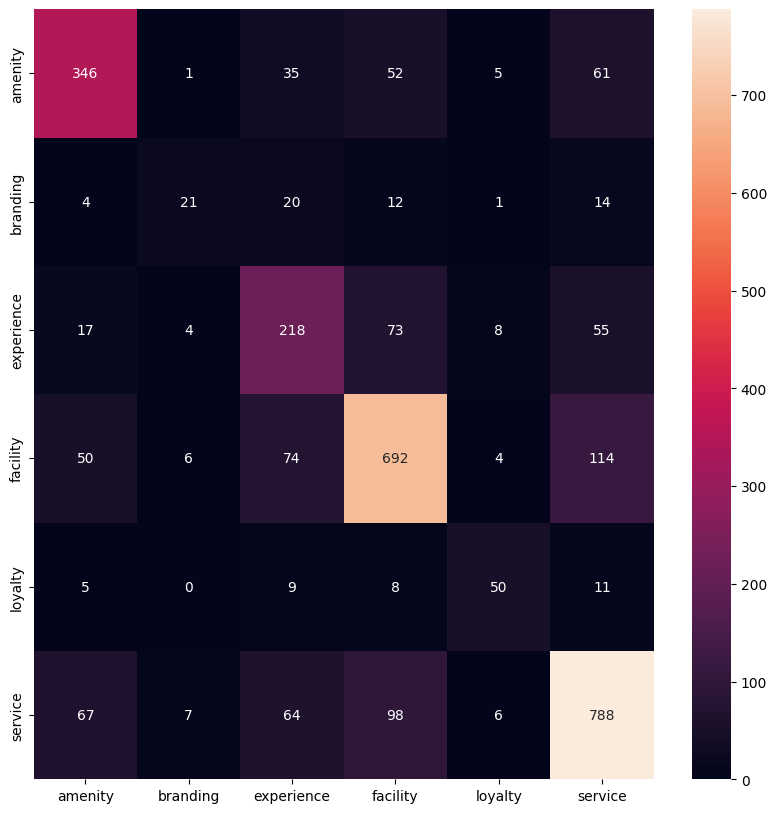

In [30]:
# Report Result
from IPython.display import display

############### Aspect term Report ####################
print('ASPECT TERM STATEMENT: \n')
print(f'Classification Report\n: {classification_report(results["Aspect"][0], results["Aspect"][1])}')
print()
print(f'Confusion Matrix: \n')
plt.figure(figsize=(10, 10))
list_aspect = ['amenity', 'branding', 'experience', 'facility', 'loyalty', 'service']
display(sns.heatmap(confusion_matrix(results["Aspect"][0], results["Aspect"][1]), annot=True, fmt='g', yticklabels = list_aspect, xticklabels = list_aspect))


SENTIMENT STATEMENT: 

Classification Report
:               precision    recall  f1-score   support

    negative       0.73      0.73      0.73       455
     neutral       0.37      0.34      0.36       128
    positive       0.94      0.95      0.95      2417

    accuracy                           0.89      3000
   macro avg       0.68      0.67      0.68      3000
weighted avg       0.89      0.89      0.89      3000


Confusion Matrix: 



<AxesSubplot: >

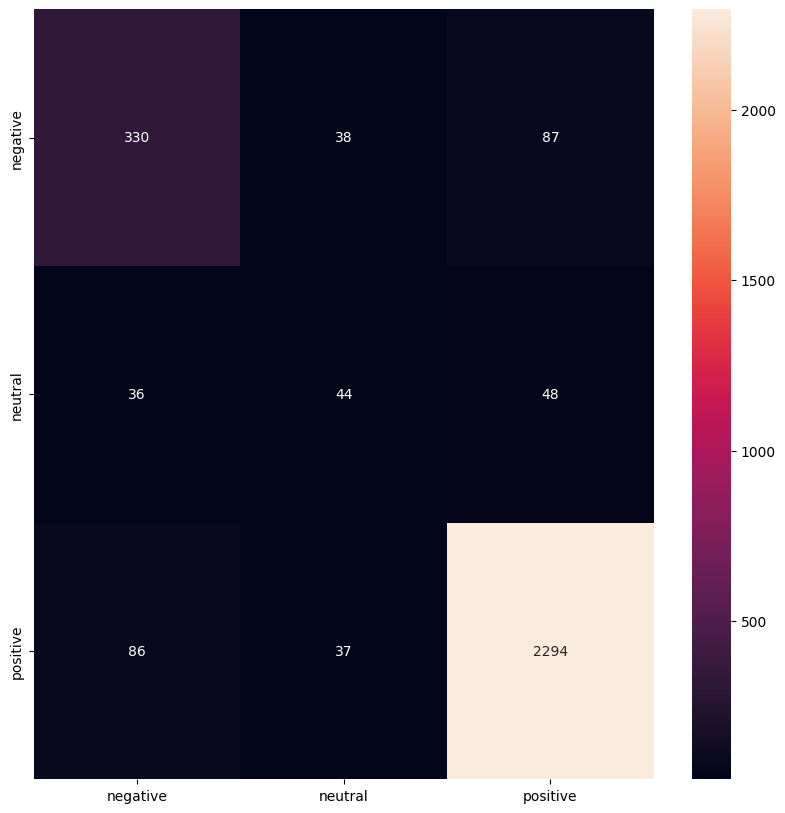

In [31]:
############### Sentiment Report ####################
print('SENTIMENT STATEMENT: \n')
print(f'Classification Report\n: {classification_report(results["Sentiment"][0], results["Sentiment"][1])}')
print()
print(f'Confusion Matrix: \n')
plt.figure(figsize=(10, 10))
list_sentiment = ['negative', 'neutral', 'positive']
display(sns.heatmap(confusion_matrix(results["Sentiment"][0], results["Sentiment"][1]), annot=True, fmt='g', yticklabels = list_sentiment, xticklabels = list_sentiment))

# Predict step

In [11]:
args = easydict.EasyDict({
        'task': 'tasd',
        'dataset': 'mydata',
        'model_name_or_path': 't5-base',
        'max_seq_length': 128,
        'train_batch_size': 16,
        'eval_batch_size': 16,
        'gradient_accumulation_steps': 1,
        'num_train_epochs': 20,
        'seed': 20,
        'weight_decay': 0.0,
        'adam_epsilon': 1e-8,
        'warmup_steps': 0.0,
        'n_gpu': 0

})



logger = logging.getLogger(__name__)
output_dir = '/content/mydata'

print("\n****** Predict on trained checkpoint ******")

    # initialize the T5 model from previous checkpoint
print(f"Load trained model")
print(
        "Note that a pretrained model is required and `do_true` should be False"
)

# tokenizer = T5Tokenizer.from_pretrained('/content/mydata')
# tfm_model = T5ForConditionalGeneration.from_pretrained('/content/mydata')

tokenizer = T5Tokenizer.from_pretrained('kisejin/T5-ASQP')
tfm_model = T5ForConditionalGeneration.from_pretrained('kisejin/T5-ASQP')

model = T5FineTuner(args, tfm_model, tokenizer)

id_user, sents, _ = read_line_examples_from_file(
    f"/notebooks/predict_file.txt"
)

print()
predict_dataset = ABSADataset_nolabel(
        tokenizer,
        data_dir='/notebooks/predict_file.txt',
        data_type="test",
        task = 'tasd',
        max_len=128,
)
predict_loader = DataLoader(predict_dataset, batch_size=32, num_workers=4)


# compute the performance scores
# scores, all_labels, all_preds = evaluate(test_loader, model, sents, check_inference = True, task = args.task)

# predict time

trainer_params = dict(
        accumulate_grad_batches=args.gradient_accumulation_steps,
        # gpus=args.n_gpu,
        devices="auto",
        gradient_clip_val=1.0,
        # max_epochs=args.num_train_epochs,
        callbacks=[LoggingCallback()],
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
)

trainer = pl.Trainer(**trainer_params)

pred = trainer.predict(model, predict_loader)
# pred = model.predict_step(predict_loader)


# write to file
log_file_path = f"results_log/predictdata.txt"
local_time = time.asctime(time.localtime(time.time()))

print('Time to predict:', local_time)
print('*'*50)

if not os.path.exists("./results_log"):
    os.mkdir("./results_log")

with open(log_file_path, "a+") as f:
    f.write(logstr)


****** Predict on trained checkpoint ******
Load trained model
Note that a pretrained model is required and `do_true` should be False


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Time to predict: Wed Dec 13 09:11:39 2023
**************************************************


NameError: name 'logstr' is not defined

In [6]:
def predict_time(data_loader, model, task = 'asqp'):
    """
    Predict time for new dataset
    """
    device = torch.device(f"cuda:{args.n_gpu}")
    model.model.to(device)

    model.model.eval()

    outputs = []

    for batch in tqdm(data_loader):
        # need to push the data to device
        outs = model.model.generate(
            input_ids=batch["source_ids"].to(device),
            attention_mask=batch["source_mask"].to(device),
            max_length=128
        )  # num_beams=8, early_stopping=True)

        dec = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outs]
        outputs.extend(dec)


    # pickle.dump(results, open(f"{args.output_dir}/results-{args.dataset}.pickle", 'wb'))

    return outputs

In [19]:
# tokenizer = T5Tokenizer.from_pretrained('kisejin/T5-ASQP')
# tfm_model = T5ForConditionalGeneration.from_pretrained('kisejin/T5-ASQP')

# model = T5FineTuner(args, tfm_model, tokenizer)


# device = torch.device(f"cuda:{args.n_gpu}")
# model.model.to(device)

# model.model.eval()

# outputs = []

# for batch in tqdm(predict_loader):
#         # need to push the data to device
#     outs = model.model.generate(
#                 input_ids=batch["source_ids"].to(device),
#                 attention_mask=batch["source_mask"].to(device),
#                 max_length=128,
#     )  # num_beams=8, early_stopping=True)

#     dec = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outs]
#     outputs.extend(dec)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['amenity is great because amazing location is great [SSEP] amenity is great because everything is near by is great [SSEP] service is great because there are free bikes available even with a child seat is great', 'service is great because friendly staff is great [SSEP] experience is great because nice hostel to get to know other travelers is great [SSEP] amenity is great because perfect location is great', 'experience is great because our stay at boutique lodge was probably the best during our month long stay in vietnam is great [SSEP] facility is great because our room was spacious and comfortable with outside seating facing the garden area and pool is great [SSEP] facility is great because the saltwater pool is luxurious is great [SSEP] experience is great because especially since this was our first warm weather place we visited in vietnam as we were traveling north to south is great [SSEP] experience is great because the early morning water market trip on taun s boat was followed up

In [7]:
tokenizer = T5Tokenizer.from_pretrained('kisejin/T5-ASQP')
tfm_model = T5ForConditionalGeneration.from_pretrained('kisejin/T5-ASQP')

model = T5FineTuner(args, tfm_model, tokenizer)

predict_dataset = ABSADataset_nolabel(
        tokenizer,
        data_dir='/notebooks/predict_file.txt',
        data_type="test",
        task = 'tasd',
        max_len=128,
)

predict_loader = DataLoader(predict_dataset, batch_size=128, num_workers=8)


pred = predict_time(predict_loader, model, task = 'tasd')

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

100%|██████████| 1998/1998 [4:40:00<00:00,  8.41s/it]  


In [14]:
import pandas as pd

df = pd.DataFrame({'pred': pred})

In [21]:
df.to_csv('notebook/predict_output.csv')

OSError: Cannot save file into a non-existent directory: 'notebook'